In [47]:
%pip install -q -U langchain-google-genai langchain_core langgraph

In [48]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [49]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash")

In [50]:
def multiply(a: int, b: int) -> int:
  """Multiplies two integers together.

  Args:
    a: The first integer.
    b: The second integer.

  Returns:
    The product of the two integers.
  """
  return a * b

def add(a: int, b: int) -> int:
  """Adds two integers together.

  Args:
    a: The first integer.
    b: The second integer.

  Returns:
    The sum of the two integers.
  """
  return a + b

In [51]:
llm_with_tools = llm.bind_tools([multiply, add])

In [52]:
# llm_with_tools.invoke("Multiply 5 by 5")

In [53]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from IPython.display import display, Image

def tool_calling_llm_node(state: MessagesState) -> MessagesState:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("Tool Calling LLM Node", tool_calling_llm_node)
builder.add_node("tools", ToolNode([multiply, add]))

builder.add_edge(START, "Tool Calling LLM Node")
builder.add_conditional_edges("Tool Calling LLM Node", tools_condition)
builder.add_edge("tools", END)

graph: CompiledStateGraph = builder.compile()

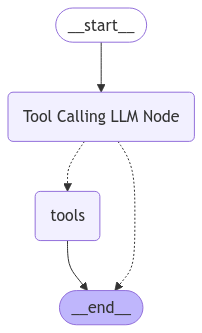

In [54]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
messages = graph.invoke({"messages": [HumanMessage(content="Multiply 5 by 5")]})

for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

Multiply 5 by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (50058442-7bc5-46d1-9fb5-84e65ea2df08)
 Call ID: 50058442-7bc5-46d1-9fb5-84e65ea2df08
  Args:
    a: 5.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

25


In [56]:
messages = graph.invoke({"messages": [HumanMessage(content="Multiply 5 by 10 then add 7")]})

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

Multiply 5 by 10 then add 7
================================== Ai Message ==================================
Tool Calls:
  multiply (82271034-f339-4606-af6f-5736ef98f70a)
 Call ID: 82271034-f339-4606-af6f-5736ef98f70a
  Args:
    a: 5.0
    b: 10.0
  add (dd9c58e5-9564-403d-a8e5-d151d0822f3b)
 Call ID: dd9c58e5-9564-403d-a8e5-d151d0822f3b
  Args:
    a: 50.0
    b: 7.0
================================= Tool Message =================================
Name: multiply

50
================================= Tool Message =================================
Name: add

57
